# Student Performance Predictor

## Import Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

### Importing Dataset

In [2]:
df = pd.read_csv('../data/math_subject_grade_prediction.csv')

### Feature Engineering

In [3]:
df['Past_Performance_Grade'] = (df.G1 + df.G2) / 2
df['Parents_Education'] = (df.Medu + df.Fedu) / 2
df['Alcohol_Consumption'] = (df.Walc + df.Dalc)

In [4]:
df.drop(['school', 'sex','G1', 'G2', 'Medu', 'Fedu', 'Dalc', 'Walc', 'guardian', 'reason'], 
        axis=1, inplace=True)

In [5]:
df.columns=['Age', 'Locality', 'Family_Size', 'Parents_Cohab_Status', 'Mother_Job',
            'Father_Job', 'Home_to_School_Travel_Time', 'Weekly_Study_Time', 'Past_Class_Failure_Count', 
            'School_Support', 'Family_Support', 'Extra_Paid_Classes', 'Extra_Curr_Activities', 
            'Attended_Kindergarten', 'Higher_Edu', 'Internet', 'Dating', 'Family_Relationship', 
            'Freetime_After_School', 'Goes_Out', 'Current_Health_Status', 'School_Absences', 
            'Final_Grade', 'Past_Grade_Record', 'Parents_Education', 'Alcohol_Consumption']

### Feature Encoding

In [9]:
onehot_cols = ['Father_Job', 'Mother_Job']
ord_enc_cols = ['School_Support', 'Family_Support', 'Higher_Edu', 'Extra_Paid_Classes', 'Locality', 
                'Family_Size', 'Parents_Cohab_Status', 'Dating', 'Extra_Curr_Activities', 
                'Attended_Kindergarten', 'Internet']


In [39]:
df_cols = list(df.columns)

In [40]:
enc_cols = onehot_cols+ord_enc_cols

In [43]:
len(df_cols), len(enc_cols)

(26, 13)

In [44]:
scaler_cols = [col for col in df_cols if col not in enc_cols]

In [56]:
scaler_cols.remove('Final_Grade')

In [80]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression

transformers = [('onehot', OneHotEncoder(sparse_output=False), onehot_cols), 
                ('ord_enc', OrdinalEncoder(), ord_enc_cols), 
                ('scaler', StandardScaler(), scaler_cols)]

col_transformer = ColumnTransformer(transformers=transformers, remainder='passthrough', 
                                   sparse_threshold=0, n_jobs=6, verbose=True)

steps = [('col_transformer', col_transformer), 
         ('kbest', SelectKBest(score_func=mutual_info_regression, k=15))]

pipeline = Pipeline(steps=steps)

In [59]:
# onehot_encoded_cols = one_hot_enc.fit_transform(df[onehot_cols])
# ord_encoded_cols = ord_enc.fit_transform(df[ord_enc_cols])

In [60]:
# df[ord_enc_cols] = ord_encoded_cols
# df[one_hot_enc.get_feature_names_out()] = onehot_encoded_cols

In [81]:
col_transformer.set_output(transform='pandas')

ColumnTransformer(n_jobs=6, remainder='passthrough', sparse_threshold=0,
                  transformers=[('onehot', OneHotEncoder(sparse_output=False),
                                 ['Father_Job', 'Mother_Job']),
                                ('ord_enc', OrdinalEncoder(),
                                 ['School_Support', 'Family_Support',
                                  'Higher_Edu', 'Extra_Paid_Classes',
                                  'Locality', 'Family_Size',
                                  'Parents_Cohab_Status', 'Dating',
                                  'Extra_Curr_Activities',
                                  'Attended_Kindergarten', 'Internet']),
                                ('scaler', StandardScaler(),
                                 ['Age', 'Home_to_School_Travel_Time',
                                  'Weekly_Study_Time',
                                  'Past_Class_Failure_Count',
                                  'Family_Relationship',
                                  'Freetime_After_School', 'Goes_Out',
                                  'Current_Health_Status', 'School_Absences',
                                  'Past_Grade_Record', 'Parents_Education',
                                  'Alcohol_Consumption'])],
                  verbose=True)

In [87]:
X = df.drop(['Final_Grade'], axis=1)
Y = df['Final_Grade']

In [88]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [89]:
col_transformer.fit(x_train)

ColumnTransformer(n_jobs=6, remainder='passthrough', sparse_threshold=0,
                  transformers=[('onehot', OneHotEncoder(sparse_output=False),
                                 ['Father_Job', 'Mother_Job']),
                                ('ord_enc', OrdinalEncoder(),
                                 ['School_Support', 'Family_Support',
                                  'Higher_Edu', 'Extra_Paid_Classes',
                                  'Locality', 'Family_Size',
                                  'Parents_Cohab_Status', 'Dating',
                                  'Extra_Curr_Activities',
                                  'Attended_Kindergarten', 'Internet']),
                                ('scaler', StandardScaler(),
                                 ['Age', 'Home_to_School_Travel_Time',
                                  'Weekly_Study_Time',
                                  'Past_Class_Failure_Count',
                                  'Family_Relationship',
                                  'Freetime_After_School', 'Goes_Out',
                                  'Current_Health_Status', 'School_Absences',
                                  'Past_Grade_Record', 'Parents_Education',
                                  'Alcohol_Consumption'])],
                  verbose=True)

In [90]:
x_train_new = pipeline.fit_transform(x_train, y_train)

In [91]:
x_train_new.shape

(316, 15)

In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR

### Model Training

In [129]:
lr = LinearRegression()
rfr = RandomForestRegressor(n_estimators=450, oob_score=True, random_state=42, n_jobs=6)
knr = KNeighborsRegressor(n_neighbors=5, weights='distance', n_jobs=6)
svr = LinearSVR(random_state=42)

In [130]:
lr.fit(x_train_new, y_train)
rfr.fit(x_train_new, y_train)
knr.fit(x_train_new, y_train)
svr.fit(x_train_new, y_train)

LinearSVR(random_state=42)

In [131]:
x_test_new = pipeline.transform(x_test)

In [132]:
lr_preds = lr.predict(x_test_new)
rfr_preds = rfr.predict(x_test_new)
knr_preds = knr.predict(x_test_new)
svr_preds = svr.predict(x_test_new)

In [133]:
from sklearn.metrics import r2_score, mean_absolute_error

In [134]:
print(f'LR Accuracy: {round(r2_score(y_test, lr_preds), 3)*100}%')
print(f'RFR Accuracy: {round(r2_score(y_test, rfr_preds), 2)*100}%')
print(f'KNR Accuracy: {round(r2_score(y_test, knr_preds), 3)*100}%')
print(f'SVR Accuracy: {round(r2_score(y_test, svr_preds), 3)*100}%')

LR Accuracy: 73.0%
RFR Accuracy: 86.0%
KNR Accuracy: 59.9%
SVR Accuracy: 76.7%


In [135]:
mean_absolute_error(y_test, rfr_preds)

1.0801969057665262

In [138]:
# from pickle import dump

# with open('../models/trained_rfr_model.pkl', 'wb') as f:
#     dump(rfr, f)

# with open('../models/trained_lr_model.pkl', 'wb') as f:
#     dump(lr, f)

# with open('../models/trained_svr_model.pkl', 'wb') as f:
#     dump(svr, f)

In [139]:
from sklearn.ensemble import StackingRegressor

In [152]:
estimators = [('rfr', rfr), ('svc', svr)]
stack = StackingRegressor(estimators = estimators, cv=5, n_jobs=6, verbose=1, )

In [153]:
stack.fit(x_train_new, y_train)

StackingRegressor(cv=5,
                  estimators=[('rfr',
                               RandomForestRegressor(n_estimators=450, n_jobs=6,
                                                     oob_score=True,
                                                     random_state=42)),
                              ('svc', LinearSVR(random_state=42))],
                  n_jobs=6, verbose=1)

In [164]:
stack_preds = stack.predict(x_test_new)

In [165]:
print(f'{round(r2_score(y_test, stack_preds)* 100, 2)} %')

85.63 %


In [166]:
mean_absolute_error(y_test, stack_preds)

1.0787550345228998

### Plotting the predictions vs original target values

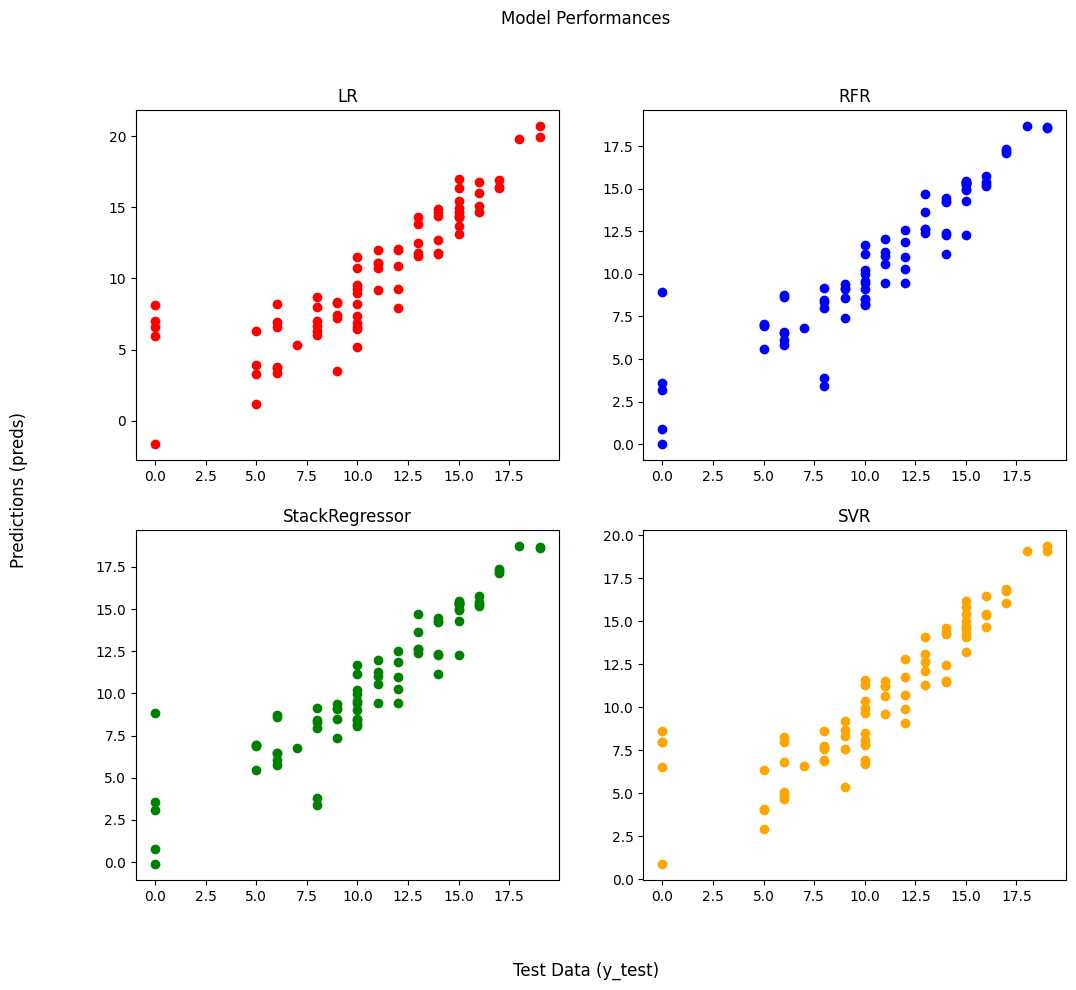

In [159]:
fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.suptitle('Model Performances')
fig.supxlabel('Test Data (y_test)')
fig.supylabel('Predictions (preds)')

axs[0][0].scatter(y_test, lr_preds, color='red')
axs[0][0].set_title('LR')
axs[0][1].scatter(y_test, rfr_preds, color='blue')
axs[0][1].set_title('RFR')
axs[1][0].scatter(y_test, stack_preds, color='green')
axs[1][0].set_title('StackRegressor')
axs[1][1].scatter(y_test, svr_preds, color='orange')
axs[1][1].set_title('SVR')

plt.savefig('../reports/Models_Performance.png')

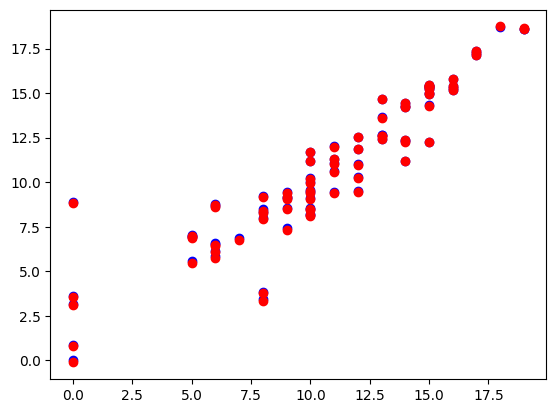

In [162]:
plt.scatter(y_test, rfr_preds, color='blue')
plt.scatter(y_test, stack_preds, color='red')
plt.show()